     Student_ID  Student_Age  Sex  High_School_Type  Scholarship  \
0      STUDENT1            0    0                 0            0   
1      STUDENT2            0    0                 0            0   
2      STUDENT3            0    0                 1            0   
3      STUDENT4            1    1                 2            0   
4      STUDENT5            0    0                 2            0   
..          ...          ...  ...               ...          ...   
140  STUDENT141            0    1                 1            0   
141  STUDENT142            1    1                 1            1   
142  STUDENT143            1    1                 2            1   
143  STUDENT144            0    1                 1            1   
144  STUDENT145            1    1                 2            2   

     Additional_Work  Sports_activity  Transportation  Weekly_Study_Hours  \
0                  0                0               0                   0   
1                  0         

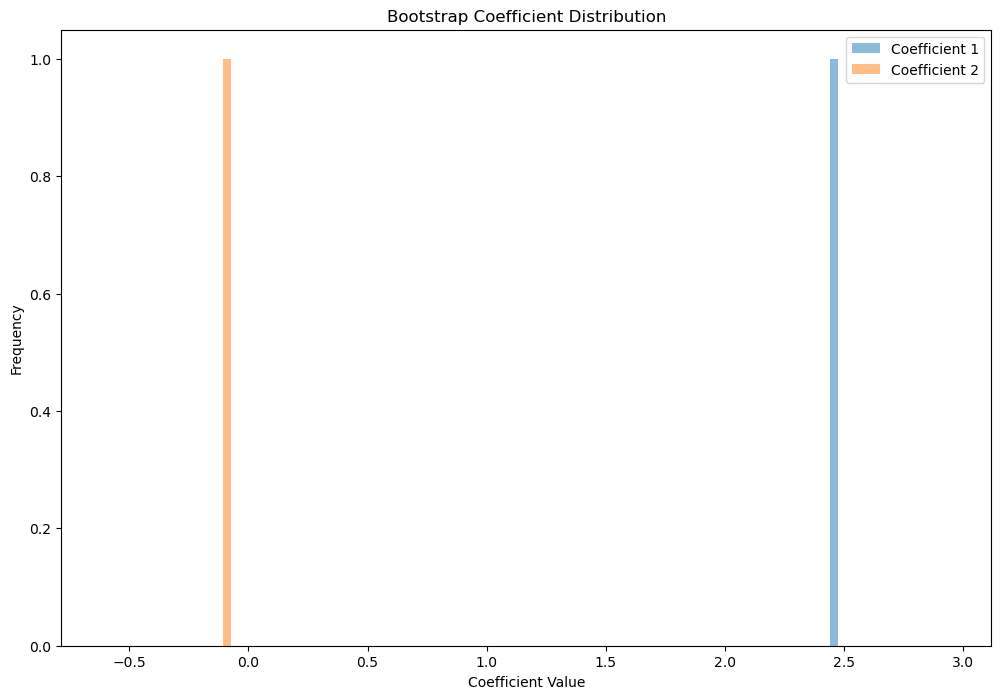

PLS-SEM analysis completed!


In [1]:
import pandas as pd 
import numpy as np
from semopy import Model
# from semopy.stats import calculate_pvalues
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.regression.linear_model import OLS
import scipy.stats as stats
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('performance.csv')

categorical_columns = ['Student_Age','Sex', 'High_School_Type', 'Scholarship', 'Additional_Work', 
                        'Sports_activity', 'Transportation', 'Attendance', 'Reading', 
                        'Notes', 'Listening_in_Class', 'Project_work', 'Grade']

for column in categorical_columns:
    unique_values = df[column].unique()
    mapping = {value: i for i, value in enumerate(unique_values)}
    df[column] = df[column].map(mapping)

print(df)


# Define SEM model with latent constructs
model_syntax = """
    # Latent constructs
    Learning_Engagement =~ Weekly_Study_Hours + Attendance
    Study_Habits =~ Reading + Listening_in_Class + Project_work
    Social_Activity =~ Additional_Work + Sports_activity
    Academic_Performance =~ Grade + Notes

    # Structural model
    Academic_Performance ~ Learning_Engagement + Study_Habits + Social_Activity
"""

# Divide the dataset into four groups
Learning_Engagement = df[['Weekly_Study_Hours', 'Attendance']]
Study_Habits = df[['Reading', 'Listening_in_Class', 'Project_work']]
Social_Activity = df[['Additional_Work', 'Sports_activity']]
Academic_Performance = df[['Grade', 'Notes']]

# Create a list of group names and data
group_names = ['demographics', 'background', 'career_transition', 'job_search_pref']
groups = [Learning_Engagement, Study_Habits, Social_Activity, Academic_Performance]

# Loop through each group
for group_name, group_data in zip(group_names, groups):
    print('******************************************')
    # table 3
    # Scaling numerical features
    scaler = StandardScaler()
    group_data_scaled = scaler.fit_transform(group_data)

    # Split data into features (X) and targets (Y)
    X = group_data_scaled
    Y = df[['Grade']].values 

    # Split data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Fit PLS model
    pls = PLSRegression(n_components=1)
    pls.fit(X_train, Y_train)

    # table 5
    # Calculate R-squared
    R_sq = pls.score(X_test, Y_test)
    print(f'R-Square for {group_name}: {R_sq}')

    # Predict Y values using the trained model
    Y_pred = pls.predict(X_test)

    path_coefficients = pls.coef_
    print("Structural Path Coefficients:")
    print(path_coefficients)

    # Number of bootstrap samples
    n_bootstrap = 1000
    bootstrap_effects = []

    # Initialize an array to store bootstrap R-squared values
    bootstrap_r_squared = np.zeros(n_bootstrap)
    coefs = []
    for i in range(n_bootstrap):
        # Bootstrap resampling
        indices = np.random.choice(len(X_train), len(X_train), replace=True)
        X_train_bootstrap = X_train[indices]
        Y_train_bootstrap = Y_train[indices]

        # Fit PLS model on bootstrap sample
        pls_bootstrap = PLSRegression(n_components=1)
        pls_bootstrap.fit(X_train_bootstrap, Y_train_bootstrap)

        # Predict Y values using the trained model
        Y_pred_bootstrap = pls_bootstrap.predict(X_test)

        # Calculate indirect effects for the bootstrap sample
        bootstrap_effect = Y_test - Y_pred_bootstrap
        bootstrap_effects.append(bootstrap_effect)

        # Calculate R-squared on the test set
        bootstrap_r_squared[i] = pls_bootstrap.score(X_test, Y_test)
        
    coefs.append(pls.coef_)
    coef_dist = np.vstack(coefs)

    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(Y_test, Y_pred)
    print(f'Mean Squared Error for {group_name}: {mse}')

    mae = mean_absolute_error(Y_test, Y_pred)
    print(f'MAE for {group_name}: {mae}')

    
    # Calculate mean and confidence interval of indirect effects
    mean_effects = np.mean(bootstrap_effects, axis=0)
    ci_lower = np.percentile(bootstrap_effects, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_effects, 97.5, axis=0)
    confidence_interval = np.percentile(bootstrap_r_squared, [2.5, 97.5])

    # Calculate mean for each bootstrap sample
    bootstrap_mean = np.mean(bootstrap_effects)

    print(f'Bootstrap Orig Estimate: {mean_effects}')
    print(f'Bootstrap Mean: {bootstrap_mean}')
    print(f'Bootstrap Confidence Interval: {confidence_interval}')

    
    direct_effects_coefficients = pls.coef_
    print("Direct Effects Coefficients:")
    print(direct_effects_coefficients)


# Extract results
coeffs = pls.coef_ 
loadings = pls.x_loadings_ 

print('Outer loadings: {}'.format(loadings))

# Bootstrap Coefficient Distribution
plt.figure(figsize=(12, 8))
for i in range(coef_dist.shape[1]):
    plt.hist(coef_dist[:, i], bins=30, alpha=0.5, label=f'Coefficient {i+1}')

plt.title('Bootstrap Coefficient Distribution')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('PLS-SEM analysis completed!')